In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats

import physio

In [3]:
data_folder = Path('/home/samuel/Documents/physio_benchmark/data')

data_file = data_folder / 'human' / 'S00.txt'

# Open data

In [4]:
data = np.loadtxt(data_file)
data.shape
raw_ecg = data[:, 0]
raw_resp = data[:, 1]

srate = 1000
times = np.arange(raw_ecg.size) / srate

# compute ecg rpeak, resp cycle and rsa

In [5]:
ecg, ecg_peaks = physio.compute_ecg(raw_ecg, srate, parameter_set='simple_ecg')
resp, resp_cycles = physio.compute_respiration(raw_resp, srate, parameter_set='human_airflow')

In [6]:
rsa_cycles, cyclic_cardiac_rate = physio.compute_rsa(resp_cycles, ecg_peaks, srate=10., two_segment=True)

In [7]:
rsa_cycles.head(5)

,peak_index,trough_index,amplitude,peak_value,trough_value,peak_time,trough_time,rising_duration,decay_duration
0,21,51,50.193323,107.696361,57.503038,2.135,5.135,NaN,3.0
1,114,139,38.499518,100.671141,62.171623,11.420,13.920,6.285,2.5
2,195,221,22.633509,97.548194,74.914685,19.506,22.106,5.586,2.6
3,277,298,47.549776,98.782549,51.232774,27.752,29.852,5.646,2.1
4,379,400,45.570177,96.724486,51.154310,37.945,40.045,8.093,2.1


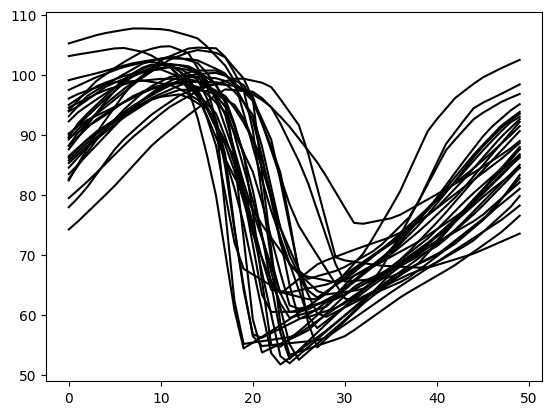

In [8]:
fig, ax = plt.subplots()
_ = ax.plot(cyclic_cardiac_rate.T, color='k')


# RSA on many subjects

In [9]:
num_subject = 15
points_per_cycle = 50


all_resp_cycles = []
all_rsa_cycles = []
all_cyclic_cardiac_rate = []
for subject_num in range(num_subject):
    subject_id = f'S{subject_num:02}'
    data_file = data_folder / 'human' / f'{subject_id}.txt'
    data = np.loadtxt(data_file)

    raw_ecg = data[:, 0]
    raw_resp = data[:, 1]

    srate = 1000
    times = np.arange(raw_ecg.size) / srate

    ecg, ecg_peaks = physio.compute_ecg(raw_ecg, srate, parameter_set='simple_ecg')
    resp, resp_cycles = physio.compute_respiration(raw_resp, srate, parameter_set='human_airflow')
    rsa_cycles, cyclic_cardiac_rate = physio.compute_rsa(resp_cycles, ecg_peaks, srate=10., 
                                points_per_cycle=points_per_cycle, two_segment=True)
    rsa_cycles['subject_id'] = subject_id

    all_resp_cycles.append(resp_cycles)
    all_rsa_cycles.append(rsa_cycles)
    all_cyclic_cardiac_rate.append(cyclic_cardiac_rate)


In [10]:
resp_cycles.columns, rsa_cycles.columns

(Index(['inspi_index', 'expi_index', 'next_inspi_index', 'inspi_time',
        'expi_time', 'next_inspi_time', 'cycle_duration', 'inspi_duration',
        'expi_duration', 'cycle_freq', 'cycle_ratio', 'inspi_volume',
        'expi_volume', 'total_amplitude', 'inspi_amplitude', 'expi_amplitude',
        'total_volume'],
       dtype='object'),
 Index(['peak_index', 'trough_index', 'amplitude', 'peak_value', 'trough_value',
        'peak_time', 'trough_time', 'rising_duration', 'decay_duration',
        'subject_id'],
       dtype='object'))

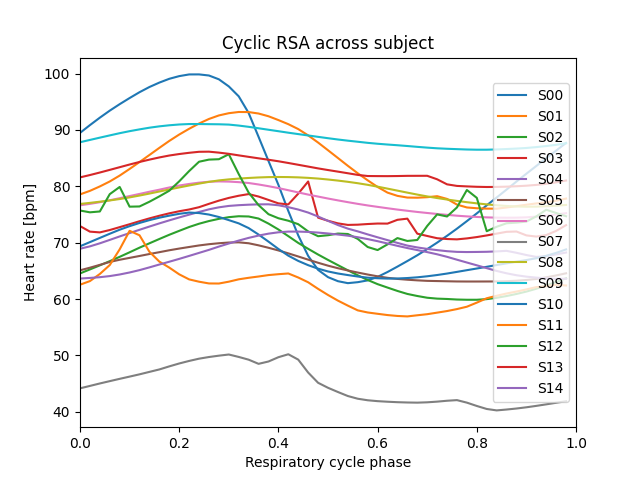

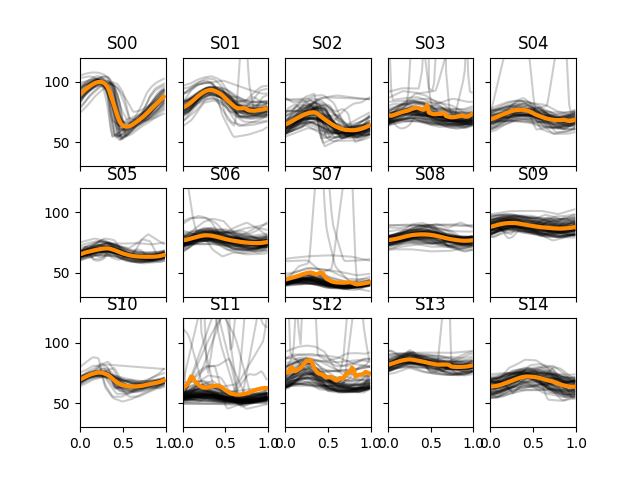

In [24]:
def make_figure_3a(ax, axs=None):


    one_cycle = np.arange(points_per_cycle) / points_per_cycle


    for subject_num in range(num_subject):
        subject_id = f'S{subject_num:02}'

        rsa_cycles = all_rsa_cycles[subject_num]
        cyclic_cardiac_rate = all_cyclic_cardiac_rate[subject_num]

        m = np.mean(cyclic_cardiac_rate, axis=0)
        if axs is not None:
            ax2 = axs.flatten()[subject_num]
            ax2.plot(one_cycle, cyclic_cardiac_rate.T, color='k', alpha=0.2)
            ax2.plot(one_cycle, m, color='darkorange', lw=3, )
            ax2.set_title(subject_id)

        ax.plot(one_cycle, m, label=subject_id)

    if axs is not None:
        axs[0, 0].set_ylim(30, 120)
        axs[0, 0].set_xlim(0, 1)

    ax.legend(loc='right')
    ax.set_xlabel('Respiratory cycle phase')
    ax.set_ylabel('Heart rate [bpm]')
    ax.set_title('Cyclic RSA across subject')
    ax.set_xlim(0, 1)

fig1, ax = plt.subplots()
fig2, axs = plt.subplots(ncols=5, nrows=3, sharex=True, sharey=True)


make_figure_3a(ax, axs)


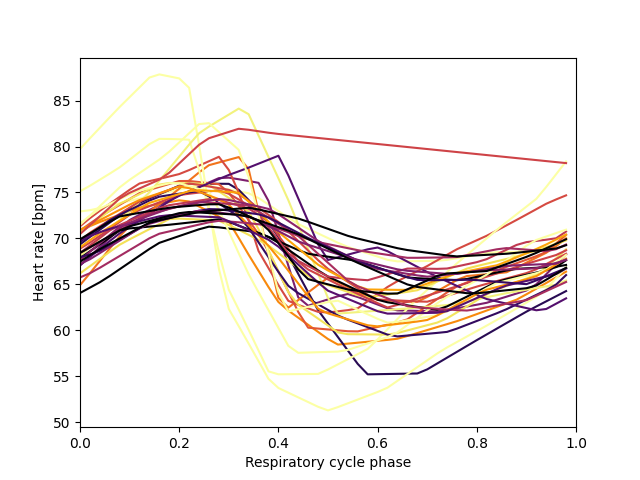

In [65]:
# %matplotlib inline
%matplotlib widget

def make_figure_3b(ax):
    subject_num = 10
    resp_cycles = all_resp_cycles[subject_num]
    rsa_cycles = all_rsa_cycles[subject_num]
    cyclic_cardiac_rate = all_cyclic_cardiac_rate[subject_num]

    one_cycle = np.arange(points_per_cycle) / points_per_cycle

    values = resp_cycles['inspi_volume'].values
    # lim0, lim1 = np.min(values), np.max(values)
    lim0, lim1 = np.quantile(values, 0.1), np.quantile(values, 0.9)

    values = (values - lim0) / (lim1 - lim0)
    values = (values * 128).astype(int)
    values = np.clip(values, 0, 127)
    cmap = plt.cm.get_cmap('inferno', 128)
    for c in range(cyclic_cardiac_rate.shape[0]):
        ax.plot(one_cycle, cyclic_cardiac_rate[c, :], color=cmap(values[c]))
    ax.set_xlim(0, 1)


    ax.set_xlabel('Respiratory cycle phase')
    ax.set_ylabel('Heart rate [bpm]')
    ax.set_xlim(0, 1)

fig, ax = plt.subplots()
make_figure_3b(ax)


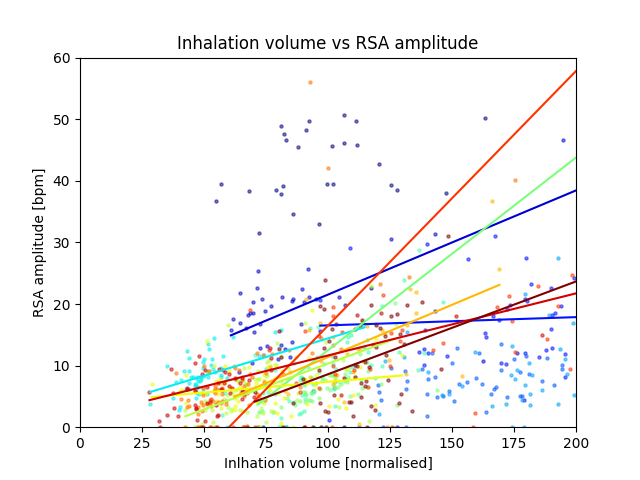

In [61]:
# %matplotlib inline
%matplotlib widget

def make_figure_3c(ax):
    cmap = plt.get_cmap('jet', num_subject)
    colors = [cmap(i) for i in range(num_subject)]
    for subject_num in range(num_subject):
        resp_cycles = all_resp_cycles[subject_num]
        rsa_cycles = all_rsa_cycles[subject_num]

        x = resp_cycles['inspi_volume'].values
        # x = x / np.std(x)
        # x = (x - np.mean(x)) / np.std(x)

        y = rsa_cycles['amplitude'].values

        ax.scatter(x, y, s=5, alpha=0.5, color=colors[subject_num])

        res = scipy.stats.linregress(x, y)

        if res.pvalue < 0.05:
            x = np.sort(x)
            y_pred = x * res.slope + res.intercept
            ax.plot(x, y_pred, color=colors[subject_num])
            # print(subject_num, res)
        


    ax.set_ylim(0, 60.)
    # ax.set_xlim(0, 8.)
    # ax.set_xlim(-8, 8.)
    ax.set_xlim(0, 200.)

    ax.set_xlabel('Inlhation volume [normalised]')
    ax.set_ylabel('RSA amplitude [bpm]')
    ax.set_title('Inhalation volume vs RSA amplitude')

fig, ax = plt.subplots()
make_figure_3c(ax)

In [14]:
rsa_cycles

,peak_index,trough_index,amplitude,peak_value,trough_value,peak_time,trough_time,rising_duration,decay_duration,subject_id
0,41,57,3.891675,75.036689,71.145015,4.177,5.777,NaN,1.6,S14
1,58,83,11.388956,71.036264,59.647308,5.851,8.351,0.074,2.5,S14
2,130,147,5.263660,72.932622,67.668962,13.081,14.781,4.730,1.7,S14
3,229,248,16.134668,69.712137,53.577469,22.980,24.880,8.199,1.9,S14
4,295,295,0.000000,64.248239,64.248239,29.588,29.588,4.708,0.0,S14
...,...,...,...,...,...,...,...,...,...,...
57,2755,2781,15.934722,75.205386,59.270664,275.545,278.145,1.711,2.6,S14
58,2825,2848,20.368734,82.152634,61.783900,282.527,284.827,4.382,2.3,S14
59,2868,2894,7.711159,71.618359,63.907200,286.885,289.485,2.058,2.6,S14
60,2920,2943,18.409957,78.226072,59.816116,292.041,294.341,2.556,2.3,S14


# make final figure3

In [16]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

[174  94  44  18  88  78  73 211 203 122 117 118  72  70  21  31  -2 -53
  65 127 128 101  96  58  56  32  49  22  45   1   0 -18  70]


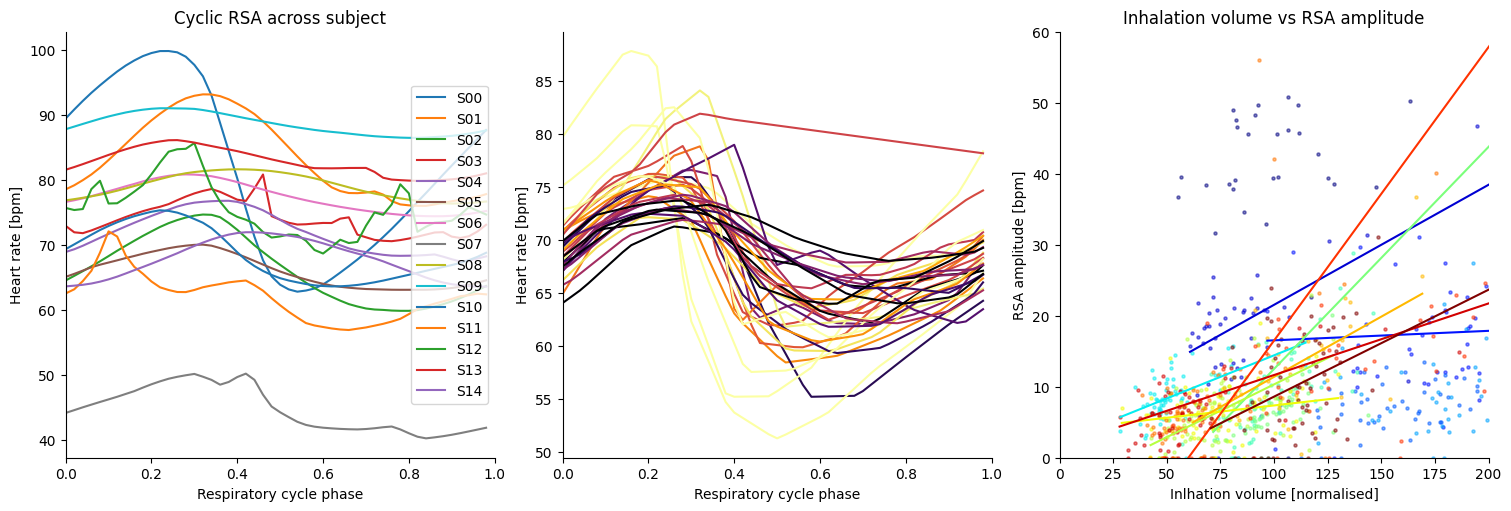

In [62]:
%matplotlib inline
fig = plt.figure(layout="constrained", figsize=(15, 5))
gs = plt.GridSpec(nrows=1, ncols=3, figure=fig)


ax = fig.add_subplot(gs[0, 0])
simpleaxis(ax)
make_figure_3a(ax)

ax = fig.add_subplot(gs[0, 1])
simpleaxis(ax)
make_figure_3b(ax)

ax = fig.add_subplot(gs[0, 2])
simpleaxis(ax)
make_figure_3c(ax)



fig.savefig('figure3.png')